# Analyzing the Warriors' Path to the NBA Championships

## Leo Edward Azucena & Gabriel Vallangca

### December 16, 2017

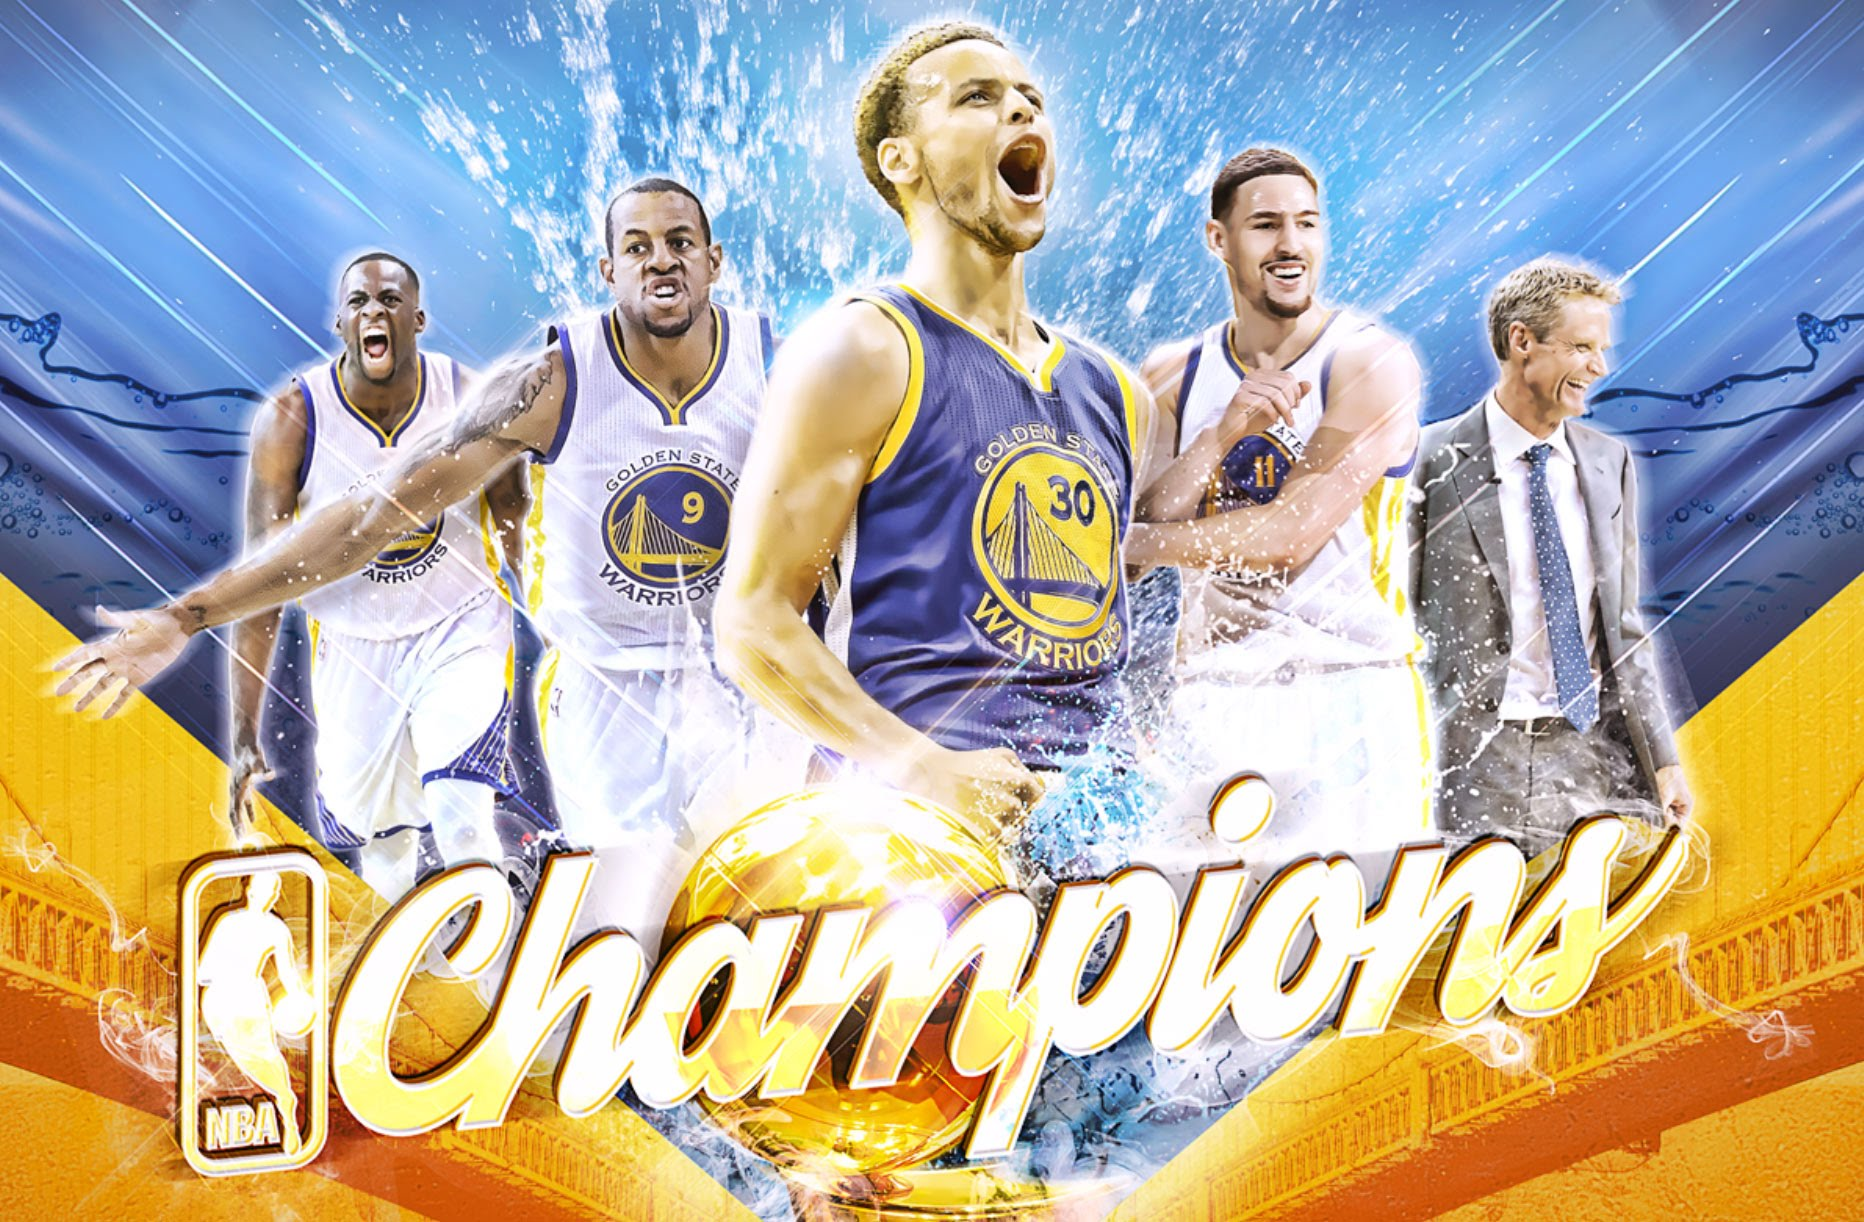

## Introduction

In the world of team sports, it is known that the players’ athletic abilities and their individual performance are  critical factors in the industry. The motivation for this final tutorial is to display the impact of analytics, a form of data science, on today's NBA.  To study the impact of analytics, we will be looking into the Box Plus/Minus of the players in the Golden State Warriors on the road to the NBA championships.

This tutorial will analyze the Golden State Warriors' statistical data with a focus on Box Plus/Minus, and will hope to verify our null hypothesis that there is a correlation with players’ individual success, specifically with Box Plus/Minus, and team success between 2009-2016 seasons. 

The first part  will include data collecting of players’ Box Plus/Minus and other supporting individual stats and data cleaning processes. The second part will demonstrate how to analyze the given data from year 2011 to 2015, and display visualization. The third part will come up with a linear regression model to process the analysis and verify the hypotheses implied from it.

Before starting, explaining Box Plus/Minus or BPM is needed in order to have a better understanding of the data during analyzation. According to Basketball-Reference’s website, BPM is a box-score based metric for evaluating players in the NBA for their performance through individual approximate contribution for their team. BPM is a per-100-possession stat: 0.0 is league average, +5 means the player is 5 points better than an average player over 100 possessions (which is about All-NBA level), -2 is replacement level, and -5 is really bad.

More explanation about Box Plus/Minus can be found here:
https://www.basketball-reference.com/about/bpm.html


## Required Tools

In order to create and share documents that contain live Python code, equations, visualizations and narrative text for data analysis in this tutoral using Jupyter Notebook is recommended; it includes data cleaning and transformation, statistical modeling, data visualization, machine learning and etc. Jupyter Notebook also has built in libraries that is needed for this tutorial, which are the following:
1. Pandas
2. Numpy
3. Scikit-learn
4. Matplotlib
6. Ggplot
5. Folium

For the dataset, the NBA players' and teams' data can be retrived at https://www.kaggle.com and https://data.world


In [1]:
#Import needed libraries
!pip install ggplot
!pip install folium
from bs4 import BeautifulSoup, SoupStrainer
import requests
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
%matplotlib inline
import ggplot
from ggplot import *
from sklearn import linear_model


    100% |████████████████████████████████| 2.2MB 286kB/s ta 0:00:01


# Part 1: Data Collection

The first thing we need to do is download the dataset at https://www.kaggle.com/drgilermo/nba-players-stats and https://data.world/gmoney/nba-team-records-by-year. The files downloaded will be in form of a CSV (comma-separated value) called Seasons_Stats.csv and in the form of a Excel sheet called Historical NBA Performance.xlsx. Then, we would have to load the files to our Jupyter Notebook in order to process the data within it. To do this, pandas libraries will help us initialize the data in nice frames and columns.  Pandas documentation can be found at:

* Complete Documentation: https://pandas.pydata.org/pandas-docs/stable/
* Pandas Cheat Sheet: https://www.datacamp.com/community/blog/python-pandas-cheat-sheet

In [2]:
# Create the dataframe from the csv file
players = pd.read_csv("Seasons_Stats.csv")
teams  = pd.read_excel("Historical NBA Performance.xlsx")

## 1.1 Data Overview
The data contains some crucial information for us to analyze such as the season year, player, age, minutes played, number of games played, position, team, and most especially, BPM. This data will be located in the Players Table.  The Team Table would consist of the season year, team, and winning percentage.

## 1.2 Data Tidying: Create Golden State Warriors Tables

When we look at the Players table, there are several columns that seem to be unnecessary to our analysis such as the number of steals, blocks field goal, and etc. In this case, we filtered out these columns since we do not need them for our analysis.  Also, since we are only focusing on the Golden State Warriors (GSW), we have cut out all the players from the other teams so we would have a table for just GSW players.

We also thought to combine some columns as it will help in our analization, such as Minutes Played per Game. There are plenty of missing statistics depending on the years so we decided to focus on the 2009-2016 seasons. 2009 is also the year Stephen Curry, the star player and captain of the championship team, got drafted by the GSW. 

In [3]:
#Filter columns that is needed
GSW = players.filter(['Year','Player', 'Age', 'G', 'MP', 'Pos','Tm', 'PER', 'BPM'], axis=1)
GSW['MP/G'] = (GSW['MP'] / GSW['G']).fillna(0).astype(int)

# For simplicity, the beginning of the season year is the name of season. (ie 2015 season is 2015-2016 season)
GSW['Year'] = GSW['Year'] - 1

# Remove seasons that are not between from 2009 - 2016 seasons
GSW = GSW.drop(GSW[GSW.Year < 2009].index)
GSW = GSW.drop(GSW[GSW.Year > 2016].index)

GSW = GSW[np.isfinite(GSW['Year'])]

# Only get top 15 players with highest Minutes Played for each season
GSW = GSW.drop(GSW[GSW.Tm != "GSW"].index)
GSW = GSW.groupby(GSW['Year'], as_index=False)
GSW = GSW.apply(lambda x : x.sort_values(by="MP", ascending=False).head(15))
GSW = GSW.reset_index().drop('level_1', 1).drop('level_0', 1)
GSW.sample(5)

,Year,Player,Age,G,MP,Pos,Tm,PER,BPM,MP/G
57,2012.0,Kent Bazemore,23.0,61.0,267.0,SG,GSW,11.3,-4.9,4
25,2010.0,Rodney Carney,26.0,25.0,331.0,SF,GSW,10.7,-4.9,13
83,2014.0,Leandro Barbosa,32.0,66.0,982.0,SG,GSW,15.3,-0.8,14
113,2016.0,Patrick McCaw,21.0,71.0,1074.0,SG,GSW,8.6,-1.7,15
100,2015.0,Festus Ezeli,26.0,46.0,770.0,C,GSW,17.7,-0.1,16


We converted the Year column in the Teams table to an integer from datetime type to match the Year column in the Players table. Also to make it compatible with the Players Table, we focused on 2009-2016 seasons as well by dropping rows that didn't fit the criteria.

In [4]:
#Filter columns that is needed
teams = teams.filter(['Year','Team', 'Winning Percentage'], axis=1)

#Convert Year data to int
teams["Year"] = teams["Year"].fillna('')
teams["Year"] = teams["Year"].apply(lambda x: int(x[:4]) if isinstance(x, str) else int(str(x.year)))

teams = teams.drop(teams[teams.Year < 2009].index)
teams = teams.drop(teams[teams.Year > 2016].index)
# warriors_bpm_stat
#Tidy the data by filtering which columns will be needed for this tutorial
teams = teams.filter(['Year','Team', 'Winning Percentage'], axis=1)
teams.sample(5).head()

,Year,Team,Winning Percentage
1366,2011,Wizards,0.303
784,2013,Bucks,0.183
343,2015,Nuggets,0.402
878,2011,Knicks,0.545
996,2014,Magic,0.305


### 1.2.1 Create Necessary Tables

#### Yearly BPM For GSW
Next, we created a statistical table for BPM which will help us later for the analysis. The table consists of the overall BPM Average, Maximum BPM, Minimum BPM, and Standard Deviation of the BPM for each year of the given seasons (2009-2016) for the Golden State Warriors.

In [5]:
#Average BPM per year from 2009 - 2016 seasons
groupByYear = GSW.groupby(GSW['Year'])
avg_BPM = groupByYear.mean().filter(['BPM'])
avg_BPM["Max"] = groupByYear.max().filter(['BPM'])
avg_BPM["Min"] = groupByYear.min().filter(['BPM'])
avg_BPM["Std"] = groupByYear.std().filter(['BPM'])
avg_BPM = avg_BPM.reset_index().rename(index=str, columns={'BPM' : 'Avg'})
avg_BPM

,Year,Avg,Max,Min,Std
0,2009.0,-1.053333,1.0,-4.3,1.455466
1,2010.0,-1.993333,1.9,-7.3,2.804452
2,2011.0,-1.566667,3.4,-7.0,2.993962
3,2012.0,-2.053333,5.4,-11.5,4.333073
4,2013.0,-0.960000,7.4,-10.6,4.563645
5,2014.0,0.726667,9.9,-6.0,3.773302
6,2015.0,0.646667,12.5,-3.9,4.187373
7,2016.0,1.586667,8.0,-2.0,3.190357


#### BPM PER AGE 
Next, we created another statistical table which consists of the Average BPM for each age, and the total number of players in each age in all given seasons (2009-2016) for the Golden State Warriors.

In [6]:
#Average BPM per Age from 2009 - 2016 seasons
groupByAge = GSW.groupby(GSW['Age'])
age_BPM = groupByAge.mean().filter(['BPM'])
age_BPM["Count"] = groupByAge.agg(['count'])['Year']
age_BPM = age_BPM.reset_index().rename(index=str, columns={'BPM' : 'Avg'})
age_BPM

,Age,Avg,Count
0,20.0,-2.625000,4
1,21.0,-3.100000,5
2,22.0,-2.187500,8
3,23.0,-0.854545,11
4,24.0,-0.392857,14
5,25.0,-0.207692,13
6,26.0,0.225000,12
7,27.0,-0.937500,8
8,28.0,1.533333,6
9,29.0,-1.063636,11


#### POSITIONS BPM
We created another statistical table for BPM which consists of the Average BPM for each position, and the total number of players in each position in all given seasons (2009-2016) for the Golden State Warriors.

In [7]:
#Average BPM per Position from 2009 - 2016 seasons
groupByPos = GSW.groupby(GSW['Pos'])
Pos_BPM = groupByPos.mean().filter(['BPM'])
Pos_BPM["Count"] = groupByPos.agg(['count'])['Year']
Pos_BPM = Pos_BPM.reset_index().rename(index=str, columns={'BPM' : 'Avg'})
Pos_BPM

,Pos,Avg,Count
0,C,-0.960606,33
1,PF,-0.634783,23
2,PG,1.650000,18
3,SF,-0.109091,22
4,SG,-2.125000,24


#### Winning Percentage Per Year

In [8]:
#Average Winning Percentage per Year from 2009 - 2016 seasons
groupByWP = teams.groupby(teams['Team'])
WP = groupByWP.apply(lambda x : x)
WP = WP.drop(WP[WP.Team != "Warriors"].index).filter(['Year', 'Winning Percentage'])
WP = WP.merge(avg_BPM).filter(['Year','Winning Percentage','Avg']).rename(index=str, columns={'Avg' : 'BPM'})
WP

,Year,Winning Percentage,BPM
0,2016,0.864,1.586667
1,2015,0.890,0.646667
2,2014,0.817,0.726667
3,2013,0.622,-0.960000
4,2012,0.573,-2.053333
5,2011,0.348,-1.566667
6,2010,0.439,-1.993333
7,2009,0.317,-1.053333


# Part 2: Data Analysis and Visualization

Now our data is ready to analyze. To properly analyze the data, we would need to visualize the data using plots in order to portray and explain the trend of BPM to the audience. Also in addition to the visualization, statistical measurement of the data is included as well.

## 2.1 Overall Visualization

### 2.1.1 BPM vs Win Rate Per Year

The first thing we would like to analyze is how scattered BPM is between the players every year in order to explain and visualize the trends in BPM each year.

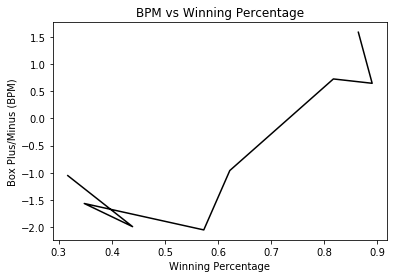

In [9]:
plt.plot(WP['Winning Percentage'], WP['BPM'], color = "black")
plt.title("BPM vs Winning Percentage")
plt.ylabel('Box Plus/Minus (BPM)')
plt.xlabel('Winning Percentage')

As seen from the plot above, there seems to be positive linear correlation between BPM and Winning Percentage for the most part.  However, the plot has also shown that the linear correlation doesn't seem to match up until about 0.58 onwards.  From the winning percentage between 0.3 and 0.58, there seems to be a downward slope for BPM so the lower the BPM the higher the winning percentage.

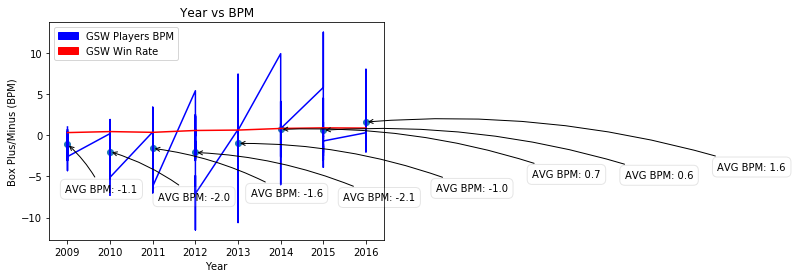

In [10]:
import matplotlib.patches as mpatches

#Plot all players' BPM per year
plt.plot(GSW['Year'], GSW['BPM'], color = "blue")
plt.plot( WP['Year'], WP['Winning Percentage'], color = "red")
plt.xticks(np.arange(2009, 2017, 1))
plt.title("Year vs BPM")
plt.ylabel('Box Plus/Minus (BPM)')
plt.xlabel('Year')
red_patch = mpatches.Patch(color='blue', label='GSW Players BPM')
green_patch = mpatches.Patch(color='red', label='GSW Win Rate')
plt.legend(handles=[red_patch,green_patch])

#Get the mean per year from the avg_BPM table created
years = avg_BPM["Year"].tolist()
mean = avg_BPM["Avg"].apply(lambda x : round(x, 1)).tolist()
labels = ['AVG BPM: {0}'.format(i) for i in mean]

#Show some visualization on where the mean stands
plt.scatter(years, mean)
x = 0
for i, txt in enumerate(years):
    txt = "AVG BPM: " + str(mean[i])
    plt.annotate(
        txt, 
        (years[i],mean[i]),
        xytext=(70 + x, -50),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=.5', fc='white', alpha=0.1),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=.1'),)
    x = x + 50

plt.rc('figure', figsize=(10, 8))
plt.show()

The graph above shows the average BPM of the Golden State Warriors slightly increasing from 2012-2016 and staying about the same from 2009-2012.  This can be attributed to the players, especially Curry, still developing, until they hit their primes at about 2014.

### 2.1.2 BPM Per Age
Second thing we would like to analyze is how BPM is correlated on the age of basketball players

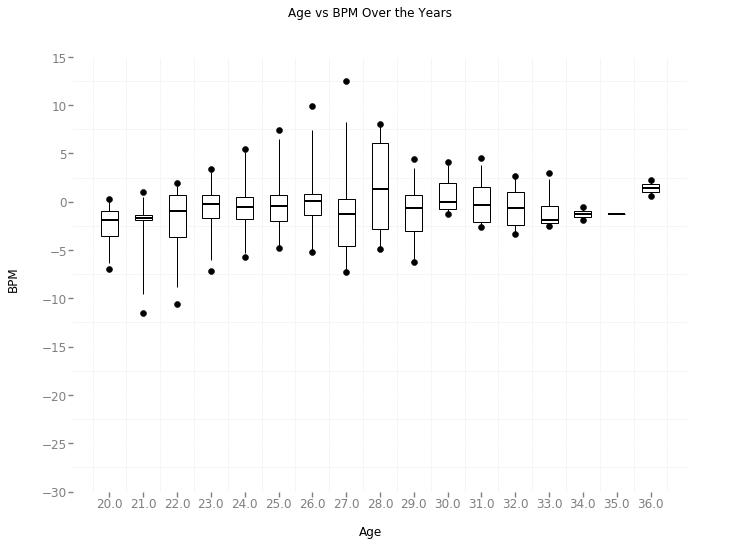

<ggplot: (-9223363289399914229)>

In [12]:
ggplot(aes(x='Age', y='BPM'), data=GSW) +\
    geom_boxplot() +\
    ylim(-30,15) +\
    theme_bw() +\
    labs(title="Age vs BPM Over the Years",
         x = "Age",
         y = "BPM")

The average BPM per age stays hovering around 0 for the most part with the highest average being at about 36 years old.  The old age would be due to players lasting that long in the league, generally being good enough to last that long so that would explain that high average compared to the younger players.  The highest peak would be at age 27, which is considered the peak age in the NBA.

### 2.1.3 BPM Per Position

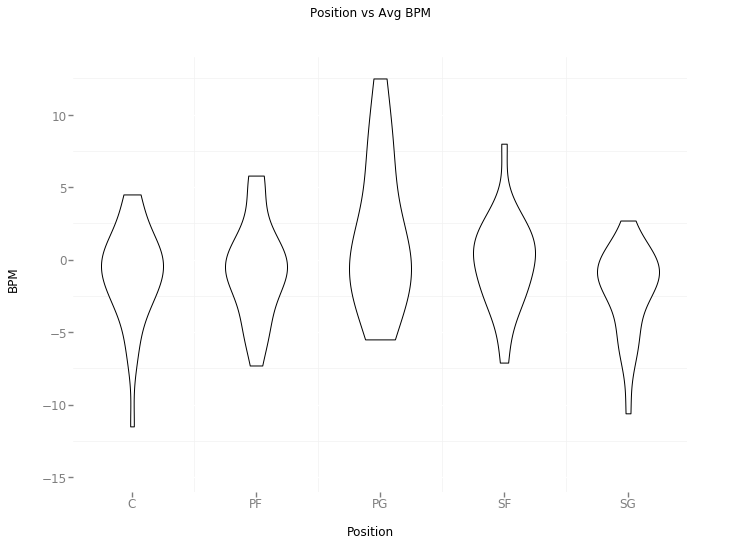

<ggplot: (-9223363289400166070)>

In [13]:
ggplot(aes(x='Pos', y='BPM'), data=GSW) +\
    geom_violin() +\
    theme_bw() +\
    ylim(-16,14) +\
    labs(title="Position vs Avg BPM",
         x = "Position",
         y = "BPM")
    

As expected, the highest BPM overall is assigned to the point guards in the GSW.  The main reason for the extremely high crest would be due to Stephen Curry, and the high BPM in the position overall can be attributed by the fact that point guards handle the ball more than other positions in general.  The position with the lowest overall BPM, surprisingly, is the shooting guard.  Arguably the second best player on the team, Klay Thompson, seems to have a low BPM compared to his peers in the other positions as even the peak of the BPM for shooting guards is the lowest.

# Part 3: Linear Regression and Hypothesis Test
## 3.1 Linear Regression on BPM by YEAR

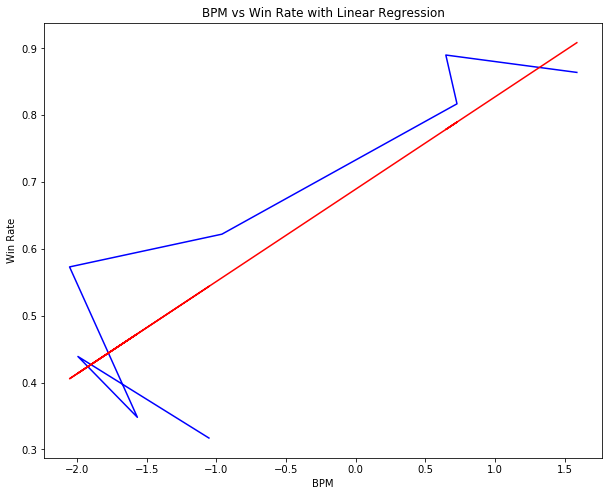

0.138117724614


In [14]:
#Linear Regression
reg = linear_model.LinearRegression()
X = [[x] for x in WP['BPM'].values]
Y = [[y] for y in WP['Winning Percentage'].values]
regfit = reg.fit(X, Y)

#Get predcited Values
pred_BPM = []
for x in WP['BPM'].values:
    pred_BPM.append(regfit.predict(x)[0][0])
WP['pred_Win'] = pd.Series(pred_BPM, index = WP.index)

#Plot the linear regression line with the data
plt.plot(WP['BPM'], WP['Winning Percentage'], color='blue',)
plt.plot(WP['BPM'], WP['pred_Win'], color='red')
plt.xlabel("BPM")
plt.ylabel("Win Rate")
plt.title("BPM vs Win Rate with Linear Regression")

plt.show()
print(regfit.coef_[0][0])

The linear regression line for the BPM vs Win Rate shows that the the higher the BPM the higher the Win Rate for the teams.  Therefore, BPM is shown to have a huge effect on whether or not a team wins a game.

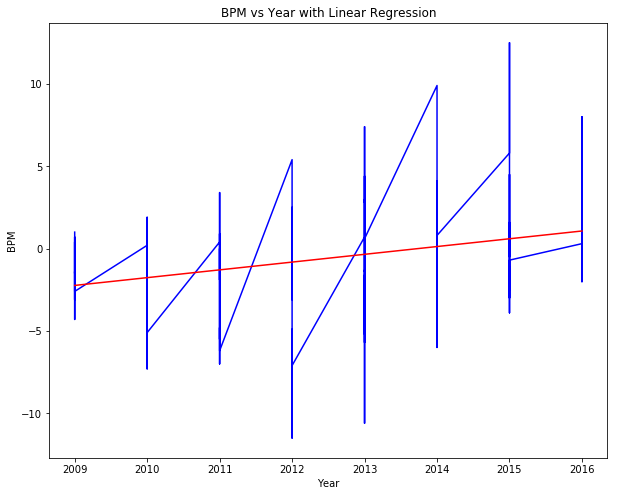

0.472063492063


In [15]:
#Linear Regression
reg = linear_model.LinearRegression()
X = [[x] for x in GSW['Year'].values]
Y = [[y] for y in GSW['BPM'].values]
regfit = reg.fit(X, Y)

#Get predcited Values
pred_BPM = []
for x in GSW['Year'].values:
    pred_BPM.append(regfit.predict(x)[0][0])
GSW['pred_BPM'] = pd.Series(pred_BPM, index = GSW.index)

#Plot the linear regression line with the data
plt.plot(GSW['Year'], GSW['BPM'], color='blue',)
plt.plot(GSW['Year'], GSW['pred_BPM'], color='red')
plt.xlabel("Year")
plt.ylabel("BPM")
plt.title("BPM vs Year with Linear Regression")

plt.show()
print(regfit.coef_[0][0])

The linear regression line for the years vs the BPM of the Golden State Warriors show that there is a a slight but gradual increase in BPM each year.  This could be caused by players getting better and better as the years go by.

## 3.2 Linear Regression on BPM by AGE

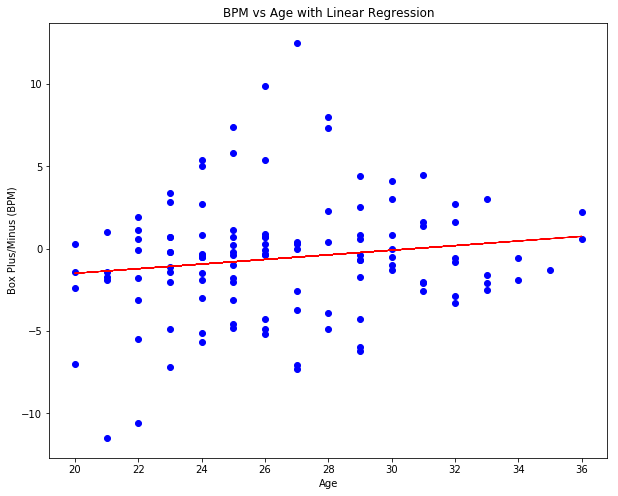

0.140278607441


In [16]:
reg = linear_model.LinearRegression()
X = [[x] for x in GSW['Age'].values]
Y = [[y] for y in GSW['BPM'].values]
regfit = reg.fit(X, Y)

BPM_pred = reg.predict(X)

plt.scatter(X, Y, color='blue')
plt.plot(X, BPM_pred, color='red', linewidth=1)

plt.title("BPM vs Age with Linear Regression")
plt.ylabel('Box Plus/Minus (BPM)')
plt.xlabel('Age')

plt.show()
print(regfit.coef_[0][0])

Based on the linear regression model, the BPM is expected to increase by 0.0941158897364 as the player gets old.  This seems to show that there is a correlation between age and BPM.

## 3.2 Linear Regressions on BPM per Positions

/opt/conda/lib/python3.6/site-packages/ggplot/stats/stat_smooth.py:77: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  smoothed_data = smoothed_data.sort('x')


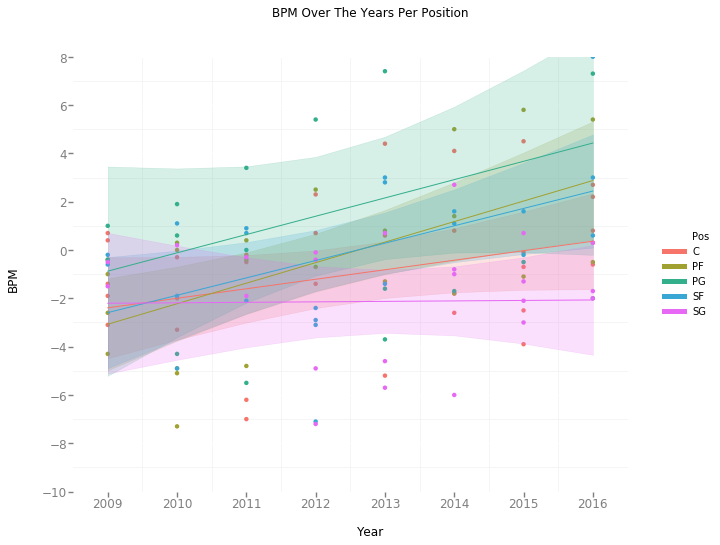

<ggplot: (8747454493346)>

In [17]:
ggplot(aes(x='Year', y='BPM', color='Pos'), data=GSW) +\
    stat_smooth(method = "lm", se=True, span=0.02) +\
    geom_point(size=20) +\
    ylim(-10,8) +\
    xlim(2008.5,2016.5) +\
    theme_bw() +\
    labs(title="BPM Over The Years Per Position",
         x = "Year",
         y = "BPM")

The positions of point guard, power forward, small forward, and center all are shown to have a positive correlation as depicted by the linear correlation model, whereas the shooting guard is shown to have a negative correlation by the model.  The power forward position has the steepest slope for the positions with positive correlation while the center position has the lowest slope.  

In [18]:
from statsmodels.formula.api import ols
#Fit the first regression
regression = ols(formula='BPM ~ Year', data=GSW).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BPM   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     11.29
Date:                Sat, 16 Dec 2017   Prob (F-statistic):            0.00105
Time:                        00:43:24   Log-Likelihood:                -320.52
No. Observations:                 120   AIC:                             645.0
Df Residuals:                     118   BIC:                             650.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -950.6111    282.792     -3.362      0.001   -1510.615    -390.607
Year           0.4721      0.141      3.359      0.001       0.194       0.750
==============================================================================
Omnibus:                        5.863   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                9.037
Skew:                           0.085   Prob(JB):                       0.0109
Kurtosis:                       4.334   Cond. No.                     1.77e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared is closer to 0 as it is 0.087 for the regression model for BPM per year so it shows that the model is not a great predictor.  The probability of the F-statistic is 0.00105 shows that the regression equation is pretty valid however.

In [19]:
#Fit the second regression
regression2 = ols(formula='BPM ~ Age', data=GSW).fit()
regression2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BPM   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.573
Date:                Sat, 16 Dec 2017   Prob (F-statistic):              0.111
Time:                        00:43:27   Log-Likelihood:                -324.70
No. Observations:                 120   AIC:                             653.4
Df Residuals:                     118   BIC:                             659.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3066      2.345     -1.836      0.069      -8.951       0.337
Age            0.1403      0.087      1.604      0.111      -0.033       0.313
==============================================================================
Omnibus:                       10.112   Durbin-Watson:                   1.188
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               15.209
Skew:                           0.398   Prob(JB):                     0.000498
Kurtosis:                       4.552   Cond. No.                         189.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
 #Fit the third regression
regression3 = ols(formula='BPM ~ Pos', data=GSW).fit()
regression3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BPM   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     3.100
Date:                Sat, 16 Dec 2017   Prob (F-statistic):             0.0183
Time:                        00:43:30   Log-Likelihood:                -319.85
No. Observations:                 120   AIC:                             649.7
Df Residuals:                     115   BIC:                             663.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9606      0.618     -1.553      0.123      -2.186       0.265
Pos[T.PF]      0.3258      0.965      0.338      0.736      -1.586       2.237
Pos[T.PG]      2.6106      1.041      2.508      0.014       0.548       4.673
Pos[T.SF]      0.8515      0.978      0.871      0.386      -1.086       2.789
Pos[T.SG]     -1.1644      0.953     -1.222      0.224      -3.052       0.724
==============================================================================
Omnibus:                        2.811   Durbin-Watson:                   1.159
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.816
Skew:                          -0.026   Prob(JB):                        0.245
Kurtosis:                       3.749   Cond. No.                         5.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R-squared and Prob(F-statistic) for the second and third models match how it was in the first model so they share the same properties as the first model in terms of the regression models and the relationships between BPM with Age and BPM with Position respectively.

# Conclusion

Based on the data acquired for the Golden State Warriors, the null hypothesis is supported in that there is a correlation between BPM of NBA players and team wins.  In addition, there is a positive correlation between BPM and the age of the players so the longer the players stay in the NBA the higher their BPM shoots up.  The data has also proven that the point guards make up the bulk of the positive BPM for the Golden State Warriors, while the shooting guards lessen the the team's average BPM.

This tutorial displays the impact that BPM has had on the championship team that is the Golden State Warriors.  Now would that be applicable to other teams and players in creating the perfect team to win the championship?  This tutorial, hopefully will spark many sports analysts to use advanced statistics like BPM more to create and develop teams in the future to provide the fans of the game, a more competitive and thrilling game.

Thank you for reading this tutorial and hopefully you have gained more knowledge about the wonderful world that is advanced statistics and basketball.

# References

- Players statistics dataset: https://www.kaggle.com/drgilermo/nba-players-stats/data
    - Players statistics CSV file: Seasons_Stats.csv
- Team statistics dataset: https://data.world/gmoney/nba-team-records-by-year/workspace/file?filename=Historical+NBA+Performance.xlsx
- Pandas Complete Documentation: https://pandas.pydata.org/pandas-docs/stable/
- Pandas Cheat Sheet: https://www.datacamp.com/community/blog/python-pandas-cheat-sheet
- Pandas groupy: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
- Matplotlib: https://matplotlib.org/
- Folium: https://folium.readthedocs.io/en/latest/
- Linear Regression Model: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- Linear Regression Model Using OLS: http://www.statsmodels.org/stable/index.html